In [1]:
import os
import numpy as np
from os import makedirs

BBO_experiments_dict = {
    "BBO MBTR/RBF baseline": os.environ["DATA"] + "/07_BBO/03_bbo_optim/v6_automatic_noise/01.01_MBTR_RBF_alpha_0_dot_1",
    "BBO MBTR/RBF normalize y": os.environ["DATA"] + "/07_BBO/03_bbo_optim/v6_automatic_noise/01.02_MBTR_RBF_alpha_0_dot_1_normalize_y",
    "BBO MBTR/RBF gridsearch": os.environ["DATA"] + "/07_BBO/03_bbo_optim/v6_automatic_noise/01.03_MBTR_RBF_alpha_gridsearch",
    "BBO MBTR/RBF whitekernel": os.environ["DATA"] + "/07_BBO/03_bbo_optim/v6_automatic_noise/01.04_MBTR_RBF_whitekernel",
    "BBO MBTR/RBF gridsearch + normalize y": os.environ["DATA"] + "/07_BBO/03_bbo_optim/v6_automatic_noise/01.05_MBTR_RBF_alpha_gridsearch_normalize_y",
    "BBO MBTR/RBF whitekernel + normalize y": os.environ["DATA"] + "/07_BBO/03_bbo_optim/v6_automatic_noise/01.06_MBTR_RBF_whitekernel_normalize_y"
}

EvoMol_experiments_dict = {
    "EvoMol rdkit": os.environ["DATA"] + "/07_BBO/03_bbo_optim/paper/01.01_EvoMol_from_methane_optim_HOMO_rdkit_nocache",
}

output_figures_root = os.environ["FIGURES"] + "/07_BBO/03_bbo_optim/v6_automatic_noise/01.10_results"
makedirs(output_figures_root, exist_ok=True)

sub_experiments_names = [str(i) for i in range(1, 11)]

ECDF_TARGETS = np.arange(-10, -1, 0.01)
ERT_TARGETS = np.arange(-10, -1, 0.5)

In [12]:
groups = [
    
    (
        "Noise study",
        ["BBO MBTR/RBF baseline", "BBO MBTR/RBF gridsearch", "BBO MBTR/RBF whitekernel", "EvoMol rdkit"],
        {
            "EvoMol rdkit": "Evolutionary optimization only",
            "BBO MBTR/RBF baseline": "BBO(MBTR, RBF) α=0.1",
            "BBO MBTR/RBF gridsearch": "BBO(MBTR, RBF) gridsearch(α)",
            "BBO MBTR/RBF whitekernel": "BBO(MBTR, RBF) whitekernel"
        },
        [0, 0, 0, 1],
        [None, None, None, None]
    ),
    
    (
        "Normalization study",
        ["BBO MBTR/RBF baseline", "BBO MBTR/RBF normalize y", "BBO MBTR/RBF gridsearch", 
         "BBO MBTR/RBF gridsearch + normalize y", "BBO MBTR/RBF whitekernel",
         "BBO MBTR/RBF whitekernel + normalize y", "EvoMol rdkit"],
        {
            "EvoMol rdkit": "Evolutionary optimization only",
            "BBO MBTR/RBF baseline": "BBO(MBTR, RBF) α=0.1",
            "BBO MBTR/RBF normalize y": "BBO(MBTR, RBF) α=0.1 norm(y)",
            "BBO MBTR/RBF gridsearch": "BBO(MBTR, RBF) gridsearch(α)",
            "BBO MBTR/RBF gridsearch + normalize y": "BBO(MBTR, RBF) gridsearch(α) norm(y)",
            "BBO MBTR/RBF whitekernel": "BBO(MBTR, RBF) whitekernel",
            "BBO MBTR/RBF whitekernel + normalize y": "BBO(MBTR, RBF) whitekernel norm(y)"
        },
        [0, 1, 0, 1, 0, 1, 0],
        [None, None, None, None, None, None, None]
    ),
    
    (
        "whitekernel+normalization",
        ["BBO MBTR/RBF whitekernel + normalize y", "EvoMol rdkit"],
        {},
        [0, 1],
        [None, None]
    )
    
   
]


In [13]:
from bbomol.postprocessing.postprocessing import extract_multiple_BBO_experiments_data, extract_multiple_evomol_experiments_data

def extract_all_data(BBO_experiments_dict, EvoMol_experiments_dict, sub_experiments_names):
    
    results_dict = {}
    
    for exp_name, path in BBO_experiments_dict.items():
        results_dict[exp_name] = extract_multiple_BBO_experiments_data(path, sub_experiments_names)
        
    for exp_name, path in EvoMol_experiments_dict.items():
        results_dict[exp_name] = extract_multiple_evomol_experiments_data(path, sub_experiments_names)

    return results_dict

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True)
from bbomol.postprocessing.evaluation import compute_ecdf, compute_best_so_far_matrix

from os.path import join
import pandas as pd
from matplotlib.ticker import FuncFormatter
linestyles = ['solid', 'dashed', 'dotted', 'dashdot', (0, (5, 10)), (0, (3, 10, 1, 10)), (0, (1, 10))]
markers = ['s', '^', 'o', '+', 'x']
from math import floor


def plot_best_so_far(results_dict, plot_title=None, exp_list_plot=None, labels_dict=None, 
                     classes_dashes=None, classes_markers=None, metric="mean"):
    
    plt.figure(figsize=(7, 5))
    
    if plot_title is not None:        
        plt.title(plot_title)
    
    if exp_list_plot is None:
        exp_list_plot = list(results_dict.keys())
        
    for i, experiment_name in enumerate(exp_list_plot):
        
        if experiment_name in exp_list_plot:
            
            if labels_dict is not None and experiment_name in labels_dict:
                display_experiment_name = labels_dict[experiment_name]
            else:
                display_experiment_name = experiment_name
                
               
            max_obj_calls = np.max([np.max(obj_calls_vect) for obj_calls_vect in results_dict[experiment_name]["dataset_success_n_calls"]])
                
            obj_calls, best_so_far_matrix = compute_best_so_far_matrix(
                results_dict[experiment_name]["dataset_success_n_calls"],
                results_dict[experiment_name]["dataset_success_obj_value"],
                max_obj_calls=max_obj_calls
            )
            
            
            if classes_dashes is None:
                linestyle = linestyles[0]
            else:
                linestyle = linestyles[classes_dashes[i]]
                
            if classes_markers is None:
                marker = None
            else:
                marker = markers[classes_markers[i]] if classes_markers[i] is not None else None
            
            if metric == "mean" or metric == "both":
                plt.plot(obj_calls, best_so_far_matrix.mean(axis=0), label=display_experiment_name, 
                         linestyle=linestyle, markevery=100)
                plt.ylabel("Best HOMO (eV)")
            if metric == "min_max" or metric == "both":
                plt.fill_between(obj_calls, best_so_far_matrix.min(axis=0), best_so_far_matrix.max(axis=0),
                                 alpha=0.2)
#                                  label=display_experiment_name, )

                
        
    plt.legend(loc="lower left")
    plt.xlim(1, 1000)
#     plt.ylim(0, 1)
    plt.xlabel("Number of DFT calls")
    plt.savefig(join(output_figures_root, "best_so_far_" + metric + "_" + plot_title +".png"), dpi=600)
    plt.show()
    

def plot_ECDF(results_dict, plot_title=None, exp_list_plot=None, exp_list_details=None, labels_dict=None, 
              classes_dashes=None, classes_markers=None):
    
    colors = sns.color_palette()
    
    plt.figure(figsize=(7, 5))
#     fig, ax = plt.subplots()
#     ax2 = ax.twinx()
#     ax.get_shared_y_axes().join(ax,ax2)
    
    if plot_title is not None:        
        plt.title(plot_title)
    
    if exp_list_plot is None:
        exp_list_plot = list(results_dict.keys())
        
    for i, experiment_name in enumerate(exp_list_plot):
        
        if experiment_name in exp_list_plot:
            
            if labels_dict is not None and experiment_name in labels_dict:
                display_experiment_name = labels_dict[experiment_name]
            else:
                display_experiment_name = experiment_name
        
            for j in range(len(results_dict[experiment_name]["dataset_success_n_calls"])):

                if exp_list_details is not None and experiment_name in exp_list_details:
                    obj_calls, ecdf_vect = compute_ecdf(
                        obj_calls_list=[results_dict[experiment_name]["dataset_success_n_calls"][j]],
                        obj_values_list=[results_dict[experiment_name]["dataset_success_obj_value"][j]],
                        targets=ECDF_TARGETS
                    )
                    sns.lineplot(obj_calls, ecdf_vect, label=display_experiment_name, color=colors[i], 
                                 dashes=[(2, 2)], style=True)
                    plt.scatter([obj_calls[-1]], [ecdf_vect[-1]], color="black")

            obj_calls, ecdf_vect = compute_ecdf(
                obj_calls_list=results_dict[experiment_name]["dataset_success_n_calls"],
                obj_values_list=results_dict[experiment_name]["dataset_success_obj_value"],
                targets=ECDF_TARGETS
            )
            
            if classes_dashes is None:
                linestyle = linestyles[0]
            else:
                linestyle = linestyles[classes_dashes[i]]
                
            if classes_markers is None:
                marker = None
            else:
                marker = markers[classes_markers[i]] if classes_markers[i] is not None else None
                
            plt.plot(obj_calls, ecdf_vect, label=display_experiment_name, linestyle=linestyle, markevery=100)
    
    
    plt.legend(loc="lower right")
    plt.xlim(1, 1000)
    plt.ylim(0, 1)
    plt.xlabel("# DFT calls")
    plt.ylabel("Proportion of targets achieved")
#     plt.hlines(0.7788, 0, 1000)
    
#     ax2.yaxis.set_major_formatter(FuncFormatter(lambda x,pos: f"{ECDF_TARGETS[int(x*len(ECDF_TARGETS))]:.0f}" if x<1 else ""))
    
#     ax2 = plt.twinx()
#     ax2.set_ylim(min(ECDF_TARGETS), max(ECDF_TARGETS))
#     ax2.set_ylabel("HOMO energy (eV)")
    
    plt.savefig(join(output_figures_root, "ecdf_" + plot_title +".png"), dpi=600)
    plt.show()

In [15]:
from bbomol.postprocessing.evaluation import compute_timestamps_ecdf

def plot_ECDF_timestamps(results_dict, plot_title=None, exp_list_plot=None, exp_list_details=None,
                         labels_dict=None, classes_dashes=None, classes_markers=None):
    
    colors = sns.color_palette()
    
    plt.figure(figsize=(7, 5))
    
    if plot_title is not None:        
        plt.title(plot_title)
    
    if exp_list_plot is None:
        exp_list_plot = list(results_dict.keys())
        
    for i, experiment_name in enumerate(exp_list_plot):
        
        if experiment_name in exp_list_plot:
            
            if labels_dict is not None and experiment_name in labels_dict:
                display_experiment_name = labels_dict[experiment_name]
            else:
                display_experiment_name = experiment_name
                
            for j in range(len(results_dict[experiment_name]["timestamps"])):

                if exp_list_details is not None and experiment_name in exp_list_details:
                    obj_calls, ecdf_vect = compute_ecdf(
                        obj_calls_list=[results_dict[experiment_name]["timestamps"][j]],
                        obj_values_list=[results_dict[experiment_name]["best_scores_timestamps"][j]],
                        targets=ECDF_TARGETS
                    )
                    sns.lineplot(obj_calls/3600, ecdf_vect, label=display_experiment_name, color=colors[i], 
                                 dashes=[(2, 2)], style=True)
                    plt.scatter([obj_calls[-1]], [ecdf_vect[-1]], color="black")
                

            obj_calls, ecdf_vect = compute_timestamps_ecdf(
                timestamps_list=results_dict[experiment_name]["timestamps"],
                obj_values_list=results_dict[experiment_name]["best_scores_timestamps"],
                targets=ECDF_TARGETS
            )
            
            if classes_dashes is None:
                linestyle = linestyles[0]
            else:
                linestyle = linestyles[classes_dashes[i]]
                
            if classes_markers is None:
                marker = None
            else:
                marker = markers[classes_markers[i]] if classes_markers[i] is not None else None
                
            plt.plot(obj_calls/3600, ecdf_vect, label=display_experiment_name, linestyle=linestyle, markevery=100)
    
    
    plt.legend(loc="lower right")
    plt.xlim(0, 60)
    plt.ylim(0, 1)
    plt.xlabel("Time (h)")
    plt.ylabel("Proportion of targets achieved")
#     ax2 = plt.twinx()
#     ax2.set_ylim(min(ECDF_TARGETS), max(ECDF_TARGETS))
#     ax2.set_ylabel("HOMO energy (eV)")
    
    plt.savefig(join(output_figures_root, "ecdf_timestamps" + plot_title +".png"), dpi=600)
    plt.show()

In [16]:
from bbomol.postprocessing.evaluation import compute_ERT, compute_ERT_timestamps
import pandas as pd
from IPython.display import display, HTML

def display_ERT(results_dict, plot_title=None, exp_list_plot=None, labels_dict=None):
    
    output_keys = ["Experiment"] + [str(value) for value in ERT_TARGETS]
    ERT_dict = {output_key: [] for output_key in output_keys}
    
    if plot_title is not None:
        display(HTML("<h3>" + plot_title +"</h3>"))

    if exp_list_plot is None:
        exp_list_plot = list(results_dict.keys())
    
    for i, experiment_name in enumerate(exp_list_plot):
        
        if labels_dict is not None and experiment_name in labels_dict:
            display_experiment_name = labels_dict[experiment_name]
        else:
            display_experiment_name = experiment_name
        
        ERT_vect = compute_ERT(
            obj_calls_list=results_dict[experiment_name]["dataset_success_n_calls"],
            obj_values_list=results_dict[experiment_name]["dataset_success_obj_value"],
            targets=ERT_TARGETS
        )
        
        ERT_dict["Experiment"].append(display_experiment_name)
        for j in range(len(ERT_vect)):
            ERT_dict[output_keys[j+1]].append(ERT_vect[j])
    
    df = pd.DataFrame.from_dict(ERT_dict)
    display(df)
    
    
def display_ERT_timestamps(results_dict, plot_title=None, exp_list_plot=None, labels_dict=None):
    
    output_keys = ["Experiment"] + [str(value) for value in ERT_TARGETS]
    ERT_dict = {output_key: [] for output_key in output_keys}
    
    if plot_title is not None:
        display(HTML("<h3>" + plot_title +"</h3>"))

    if exp_list_plot is None:
        exp_list_plot = list(results_dict.keys())
    
    for i, experiment_name in enumerate(exp_list_plot):
        
        if labels_dict is not None and experiment_name in labels_dict:
            display_experiment_name = labels_dict[experiment_name]
        else:
            display_experiment_name = experiment_name
                    
        ERT_vect = compute_ERT_timestamps(
            timestamps_list=results_dict[experiment_name]["timestamps"],
            obj_values_list=results_dict[experiment_name]["best_scores_timestamps"],
            targets=ERT_TARGETS,
            effective_last_timestamp_list=results_dict[experiment_name]["effective_last_timestamp"]
        )
        
        ERT_dict["Experiment"].append(display_experiment_name)
        for j in range(len(ERT_vect)):
            ERT_dict[output_keys[j+1]].append(ERT_vect[j])
    
    df = pd.DataFrame.from_dict(ERT_dict)
    display(df)

In [17]:
import itertools

def display_stable_proportion(results_dict, plot_title=None, exp_list_plot=None, labels_dict=None):
    
    output_keys = ["Experiment", "# Stable", "# Generated", "Stable proportion (%)", "# Unique stable",
                   "# Unique generated", "Unique stable proportion (%)", "Unique stable ∩ unstable"]
    output_dict = {output_key: [] for output_key in output_keys}
    
    if plot_title is not None:
        display(HTML("<h3>" + plot_title +"</h3>"))

    if exp_list_plot is None:
        exp_list_plot = list(results_dict.keys())
        
    for i, experiment_name in enumerate(exp_list_plot):

        if labels_dict is not None and experiment_name in labels_dict:
            display_experiment_name = labels_dict[experiment_name]
        else:
            display_experiment_name = experiment_name
            
        stable_smiles = list(itertools.chain(*results_dict[experiment_name]["dataset_success_smiles"]))
        unstable_smiles = list(itertools.chain(*results_dict[experiment_name]["dataset_failed_smiles"]))
            
        stable_smiles_unique = list(np.unique(stable_smiles))
        unstable_smiles_unique = list(np.unique(unstable_smiles))
        
        intersection = np.intersect1d(stable_smiles_unique, unstable_smiles_unique)
            
        n_stable = len(stable_smiles)
        n_unstable = len(unstable_smiles)
        n_unique_stable = len(stable_smiles_unique)
        n_unique_unstable = len(unstable_smiles_unique)
        
        total_smiles = n_stable + n_unstable
        total_unique_smiles = n_unique_stable + n_unique_unstable

        stable_prop = n_stable / total_smiles * 100
        unique_stable_prop = n_unique_stable / total_unique_smiles * 100
        
        output_dict["Experiment"].append(display_experiment_name)
        
        output_dict["# Stable"].append(n_stable)
        output_dict["# Generated"].append(total_smiles)
        output_dict["Stable proportion (%)"].append(stable_prop)

        output_dict["# Unique stable"].append(n_unique_stable)
        output_dict["# Unique generated"].append(total_unique_smiles)
        output_dict["Unique stable proportion (%)"].append(unique_stable_prop)
        
        output_dict["Unique stable ∩ unstable"].append(len(intersection))
    
    df = pd.DataFrame.from_dict(output_dict)
    display(df)
    
def plot_stable_dynamics(results_dict, plot_title=None, exp_list_plot=None, labels_dict=None,
                         classes_dashes=None, classes_markers=None):
    
    if exp_list_plot is None:
        exp_list_plot = list(results_dict.keys())
    
    plt.figure(figsize=(8, 6))
    plt.xscale("linear")
    
    for i, experiment_name in enumerate(exp_list_plot):

        if labels_dict is not None and experiment_name in labels_dict:
            display_experiment_name = labels_dict[experiment_name]
        else:
            display_experiment_name = experiment_name
            
        stable_n_calls = np.array(list(itertools.chain(*results_dict[experiment_name]["dataset_success_n_calls"])))
        unstable_n_calls = np.array(list(itertools.chain(*results_dict[experiment_name]["dataset_failed_n_calls"])))
        ecdf = np.zeros((1000,))
        
        for j in range(1000):
            ecdf[j] = np.sum(unstable_n_calls <=j)

            
        if classes_dashes is None:
            linestyle = linestyles[0]
        else:
            linestyle = linestyles[classes_dashes[i]]

        if classes_markers is None:
            marker = None
        else:
            marker = markers[classes_markers[i]] if classes_markers[i] is not None else None
            
        plt.plot(np.arange(1000), ecdf, label=display_experiment_name, linestyle=linestyle, marker=marker,
                 markevery=100)
        plt.xlabel("# DFT calls")
        plt.ylabel("# unstable solutions (cumulative)")
    
    plt.legend()
    plt.savefig(join(output_figures_root, "unstable_cumulative_" + plot_title +".png"), dpi=300)
    plt.show()
        


In [18]:
def display_times(results_dict, plot_title=None, exp_list_plot=None, labels_dict=None):

    output_keys = ["Experiment", "Mean step time", "Mean fit time", "Mean optim. time", "Mean desc. obj. comput. time"]
    output_dict = {output_key: [] for output_key in output_keys}
    
    if plot_title is not None:
        display(HTML("<h3>" + plot_title +"</h3>"))

    if exp_list_plot is None:
        exp_list_plot = list(results_dict.keys())

    for i, experiment_name in enumerate(exp_list_plot):

        if labels_dict is not None and experiment_name in labels_dict:
            display_experiment_name = labels_dict[experiment_name]
        else:
            display_experiment_name = experiment_name
            
        if "steps_step_duration" in results_dict[experiment_name]:
            mean_step_time = np.mean(list(itertools.chain(*results_dict[experiment_name]["steps_step_duration"])))
            mean_optim_time = np.mean(list(itertools.chain(*results_dict[experiment_name]["steps_optim_duration"])))
            mean_desc_obj_time = np.mean(list(itertools.chain(*results_dict[experiment_name]["steps_desc_obj_comput_duration"])))
            mean_fit_time = np.mean(list(itertools.chain(*results_dict[experiment_name]["steps_fit_duration"])))
        else:
            mean_step_time = None
            mean_optim_time = None
            mean_desc_obj_time = None
        
        output_dict["Experiment"].append(display_experiment_name)
        output_dict["Mean step time"].append(mean_step_time)
        output_dict["Mean optim. time"].append(mean_optim_time)
        output_dict["Mean desc. obj. comput. time"].append(mean_desc_obj_time)
        output_dict["Mean fit time"].append(mean_fit_time)
        
    df = pd.DataFrame.from_dict(output_dict)
    display(df)
        

In [19]:
def plot_fit_times(results_dict, plot_title=None, exp_list_plot=None, exp_list_details=None, labels_dict=None, 
              classes_dashes=None, classes_markers=None):
    
    colors = sns.color_palette()
    
    plt.figure(figsize=(7, 5))
    
    if plot_title is not None:        
        plt.title(plot_title)
    
    if exp_list_plot is None:
        exp_list_plot = list(results_dict.keys())
        
    for i, experiment_name in enumerate(exp_list_plot):
        
        if experiment_name in exp_list_plot:
            
            if labels_dict is not None and experiment_name in labels_dict:
                display_experiment_name = labels_dict[experiment_name]
            else:
                display_experiment_name = experiment_name
            
            if classes_dashes is None:
                linestyle = linestyles[0]
            else:
                linestyle = linestyles[classes_dashes[i]]
                
            if classes_markers is None:
                marker = None
            else:
                marker = markers[classes_markers[i]] if classes_markers[i] is not None else None
                
            plt.plot(results_dict[experiment_name]["dataset_success_n_calls"], 
                     results_dict[experiment_name]["steps_fit_duration"], label=display_experiment_name, 
                     linestyle=linestyle, markevery=100)
    
    
    plt.legend(loc="lower right")
    plt.xlim(1, 1000)
    plt.ylim(0, 1)
    plt.xlabel("# DFT calls")
    plt.ylabel("Proportion of targets achieved")

    plt.savefig(join(output_figures_root, "ecdf_" + plot_title +".png"), dpi=600)
    plt.show()

In [20]:
results_dict = extract_all_data(BBO_experiments_dict, EvoMol_experiments_dict, sub_experiments_names)

# Best so far  (mean)

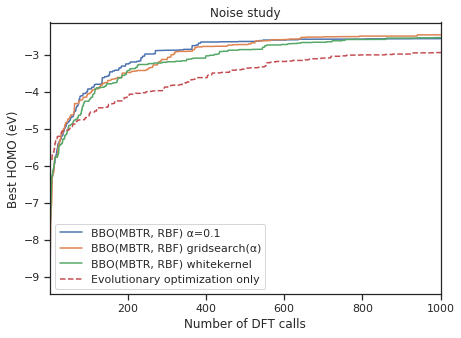

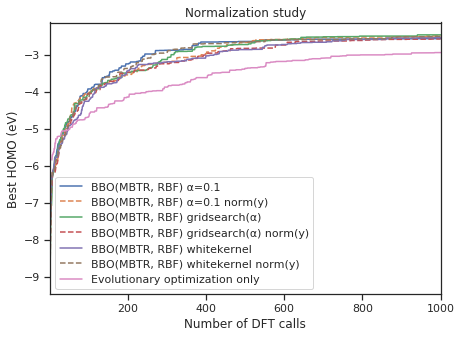

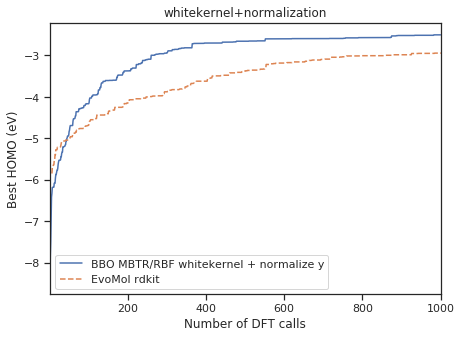

In [21]:
for group in groups:
    plot_best_so_far(results_dict, group[0], group[1], labels_dict=group[2], classes_dashes=group[3],
                     classes_markers=group[4], metric="mean")

# Best so far (min_max)

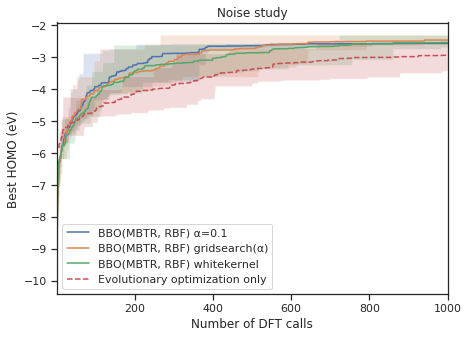

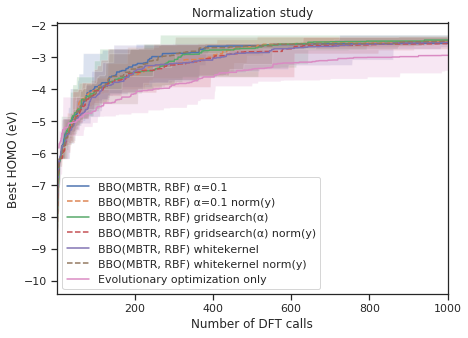

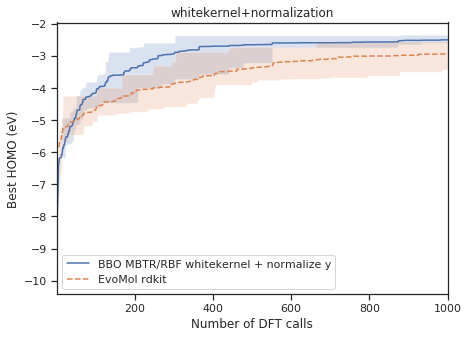

In [22]:
for group in groups:
    plot_best_so_far(results_dict, group[0], group[1], labels_dict=group[2], classes_dashes=group[3],
                     classes_markers=group[4], metric="both")

# ECDF (Empirical cumulative distribution functions)

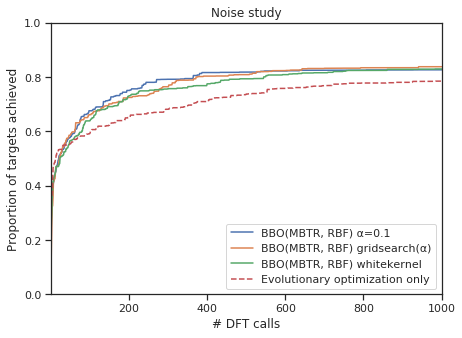

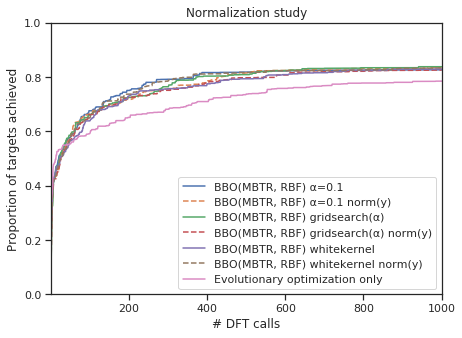

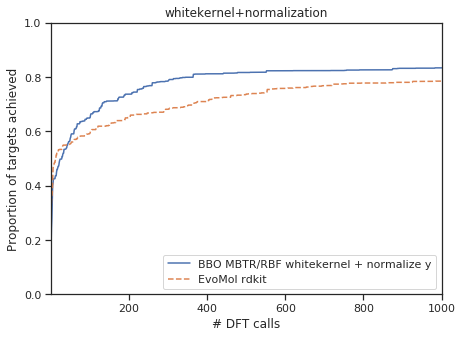

In [23]:
for group in groups:
    plot_ECDF(results_dict, group[0], group[1], labels_dict=group[2], classes_dashes=group[3],
              classes_markers=group[4])

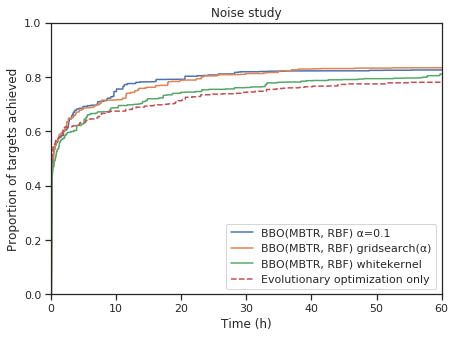

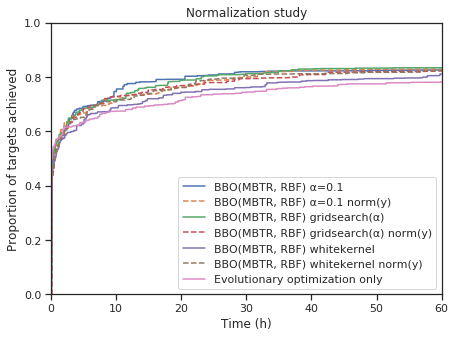

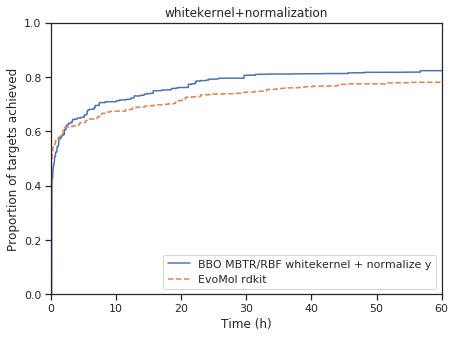

In [24]:
for group in groups:
    plot_ECDF_timestamps(results_dict, group[0], group[1], labels_dict=group[2], classes_dashes=group[3],
              classes_markers=group[4])

# ERT (Expected running time)

In [25]:
for group in groups:
    display_ERT(results_dict, group[0], group[1], labels_dict=group[2])

Experiment  -10.0  -9.5  -9.0  -8.5  -8.0  -7.5  -7.0  \
0            BBO(MBTR, RBF) α=0.1    1.4   1.6   1.6   1.6   1.8   3.2   3.6   
1    BBO(MBTR, RBF) gridsearch(α)    1.6   2.0   2.0   2.0   2.8   4.7   4.9   
2      BBO(MBTR, RBF) whitekernel    1.1   1.1   1.1   1.3   1.8   3.7   3.7   
3  Evolutionary optimization only    1.6   1.6   2.0   2.0   2.0   2.0   2.0   

   -6.5  -6.0  -5.5  -5.0   -4.5   -4.0   -3.5         -3.0    -2.5  -2.0  \
0   4.5  14.4  22.1  41.1   72.3   95.4  201.2   223.100000     inf   inf   
1   5.8  16.0  23.0  36.6   68.9  102.9  256.5   330.100000  1505.0   inf   
2   4.2  17.7  28.6  47.8   85.2  140.2  253.9   402.200000  4642.0   inf   
3   4.1   5.3  10.5  45.6  170.4  235.1  522.9  1185.666667     inf   inf   

   -1.5  
0   inf  
1   inf  
2   inf  
3   inf

Experiment  -10.0  -9.5  -9.0  -8.5  -8.0  -7.5  \
0                  BBO(MBTR, RBF) α=0.1    1.4   1.6   1.6   1.6   1.8   3.2   
1          BBO(MBTR, RBF) α=0.1 norm(y)    1.2   1.2   1.2   1.2   2.0   3.1   
2          BBO(MBTR, RBF) gridsearch(α)    1.6   2.0   2.0   2.0   2.8   4.7   
3  BBO(MBTR, RBF) gridsearch(α) norm(y)    1.2   1.8   1.8   2.2   2.2   4.1   
4            BBO(MBTR, RBF) whitekernel    1.1   1.1   1.1   1.3   1.8   3.7   
5    BBO(MBTR, RBF) whitekernel norm(y)    1.3   1.3   1.3   1.3   1.7   3.7   
6        Evolutionary optimization only    1.6   1.6   2.0   2.0   2.0   2.0   

   -7.0  -6.5  -6.0  -5.5  -5.0   -4.5   -4.0   -3.5         -3.0     -2.5  \
0   3.6   4.5  14.4  22.1  41.1   72.3   95.4  201.2   223.100000      inf   
1   3.1   4.1  18.8  29.3  43.2   60.4   94.7  238.4   342.400000  1665.60   
2   4.9   5.8  16.0  23.0  36.6   68.9  102.9  256.5   330.100000  1505.00   
3   4.1   5.2  21.2  28.3  46.8   70.7  117.2  300.2   356.900000  4716.00   
4   3.7   4.2  17.7  28.6  47.8   85.2  140.2  253.9   402.200000  4642.00   
5   4.4   4.6  17.4  30.5  42.5   74.2  110.9  224.8   263.500000  2192.75   
6   2.0   4.1   5.3  10.5  45.6  170.4  235.1  522.9  1185.666667      inf   

   -2.0  -1.5  
0   inf   inf  
1   inf   inf  
2   inf   inf  
3   inf   inf  
4   inf   inf  
5   inf   inf  
6   inf   inf

Experiment  -10.0  -9.5  -9.0  -8.5  -8.0  \
0  BBO MBTR/RBF whitekernel + normalize y    1.3   1.3   1.3   1.3   1.7   
1                            EvoMol rdkit    1.6   1.6   2.0   2.0   2.0   

   -7.5  -7.0  -6.5  -6.0  -5.5  -5.0   -4.5   -4.0   -3.5         -3.0  \
0   3.7   4.4   4.6  17.4  30.5  42.5   74.2  110.9  224.8   263.500000   
1   2.0   2.0   4.1   5.3  10.5  45.6  170.4  235.1  522.9  1185.666667   

      -2.5  -2.0  -1.5  
0  2192.75   inf   inf  
1      inf   inf   inf

## ERT Timestamps

In [26]:
for group in groups:
    display_ERT_timestamps(results_dict, group[0], group[1], labels_dict=group[2])

Experiment  -10.0   -9.5   -9.0   -8.5   -8.0   -7.5  \
0            BBO(MBTR, RBF) α=0.1  290.0  290.0  290.0  290.0  290.0  290.0   
1    BBO(MBTR, RBF) gridsearch(α)  360.0  360.0  360.0  360.0  360.0  360.0   
2      BBO(MBTR, RBF) whitekernel  410.0  410.0  410.0  410.0  410.0  410.0   
3  Evolutionary optimization only  110.0  110.0  130.0  130.0  130.0  130.0   

    -7.0   -6.5    -6.0    -5.5    -5.0     -4.5     -4.0      -3.5  \
0  290.0  290.0   620.0  1120.0  3800.0   9400.0  15110.0   38110.0   
1  360.0  360.0   900.0  1490.0  3140.0   8510.0  15940.0   48120.0   
2  410.0  410.0  1400.0  2540.0  5820.0  15700.0  36510.0   77830.0   
3  130.0  160.0   240.0   380.0  2350.0  21090.0  33550.0  107710.0   

            -3.0          -2.5  -2.0  -1.5  
0   44180.000000           inf   inf   inf  
1   67010.000000  5.134983e+05   inf   inf  
2  146560.000000  2.299018e+06   inf   inf  
3  267243.028123           inf   inf   inf

Experiment  -10.0   -9.5   -9.0   -8.5   -8.0  \
0                  BBO(MBTR, RBF) α=0.1  290.0  290.0  290.0  290.0  290.0   
1          BBO(MBTR, RBF) α=0.1 norm(y)  330.0  330.0  330.0  330.0  330.0   
2          BBO(MBTR, RBF) gridsearch(α)  360.0  360.0  360.0  360.0  360.0   
3  BBO(MBTR, RBF) gridsearch(α) norm(y)  480.0  480.0  480.0  480.0  480.0   
4            BBO(MBTR, RBF) whitekernel  410.0  410.0  410.0  410.0  410.0   
5    BBO(MBTR, RBF) whitekernel norm(y)  420.0  420.0  420.0  420.0  420.0   
6        Evolutionary optimization only  110.0  110.0  130.0  130.0  130.0   

    -7.5   -7.0   -6.5    -6.0    -5.5    -5.0     -4.5     -4.0      -3.5  \
0  290.0  290.0  290.0   620.0  1120.0  3800.0   9400.0  15110.0   38110.0   
1  330.0  330.0  330.0  1360.0  2100.0  4250.0   8380.0  16270.0   52060.0   
2  360.0  360.0  360.0   900.0  1490.0  3140.0   8510.0  15940.0   48120.0   
3  480.0  480.0  480.0  1540.0  2490.0  4900.0   9530.0  20000.0   62280.0   
4  410.0  410.0  410.0  1400.0  2540.0  5820.0  15700.0  36510.0   77830.0   
5  420.0  420.0  420.0  1250.0  2510.0  4370.0  11080.0  24240.0   63540.0   
6  130.0  130.0  160.0   240.0   380.0  2350.0  21090.0  33550.0  107710.0   

            -3.0          -2.5  -2.0  -1.5  
0   44180.000000           inf   inf   inf  
1   76340.000000  6.119183e+05   inf   inf  
2   67010.000000  5.134983e+05   inf   inf  
3   74110.000000  1.832009e+06   inf   inf  
4  146560.000000  2.299018e+06   inf   inf  
5   75930.000000  1.139004e+06   inf   inf  
6  267243.028123           inf   inf   inf

Experiment  -10.0   -9.5   -9.0   -8.5   -8.0  \
0  BBO MBTR/RBF whitekernel + normalize y  420.0  420.0  420.0  420.0  420.0   
1                            EvoMol rdkit  110.0  110.0  130.0  130.0  130.0   

    -7.5   -7.0   -6.5    -6.0    -5.5    -5.0     -4.5     -4.0      -3.5  \
0  420.0  420.0  420.0  1250.0  2510.0  4370.0  11080.0  24240.0   63540.0   
1  130.0  130.0  160.0   240.0   380.0  2350.0  21090.0  33550.0  107710.0   

            -3.0          -2.5  -2.0  -1.5  
0   75930.000000  1.139004e+06   inf   inf  
1  267243.028123           inf   inf   inf

# Times

In [27]:
for group in groups:
    display_times(results_dict, group[0], group[1], labels_dict=group[2])

Experiment  Mean step time  Mean fit time  \
0            BBO(MBTR, RBF) α=0.1     4386.862896       2.003224   
1    BBO(MBTR, RBF) gridsearch(α)     3920.754921     123.421630   
2      BBO(MBTR, RBF) whitekernel     5008.715263       3.175128   
3  Evolutionary optimization only             NaN       3.175128   

   Mean optim. time  Mean desc. obj. comput. time  
0         70.083118                   4314.768012  
1         72.293256                   3725.029851  
2         80.354558                   4925.175780  
3               NaN                           NaN

Experiment  Mean step time  Mean fit time  \
0                  BBO(MBTR, RBF) α=0.1     4386.862896       2.003224   
1          BBO(MBTR, RBF) α=0.1 norm(y)     3989.678697       2.191678   
2          BBO(MBTR, RBF) gridsearch(α)     3920.754921     123.421630   
3  BBO(MBTR, RBF) gridsearch(α) norm(y)     4010.023507     123.772103   
4            BBO(MBTR, RBF) whitekernel     5008.715263       3.175128   
5    BBO(MBTR, RBF) whitekernel norm(y)     5257.134517       2.621273   
6        Evolutionary optimization only             NaN       2.621273   

   Mean optim. time  Mean desc. obj. comput. time  
0         70.083118                   4314.768012  
1         71.073546                   3916.404274  
2         72.293256                   3725.029851  
3         76.276804                   3809.964052  
4         80.354558                   4925.175780  
5         76.634790                   5177.869243  
6               NaN                           NaN

Experiment  Mean step time  Mean fit time  \
0  BBO MBTR/RBF whitekernel + normalize y     5257.134517       2.621273   
1                            EvoMol rdkit             NaN       2.621273   

   Mean optim. time  Mean desc. obj. comput. time  
0          76.63479                   5177.869243  
1               NaN                           NaN

ValueError: setting an array element with a sequence.

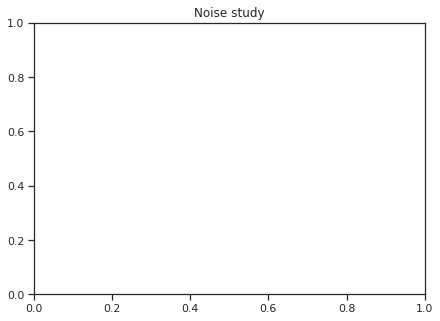

In [28]:
for group in groups:
    plot_fit_times(results_dict, group[0], group[1], labels_dict=group[2], classes_dashes=group[3],
              classes_markers=group[4])

# Proportion of stable solutions 

In [ ]:
for group in groups:
    display_stable_proportion(results_dict, group[0], group[1], labels_dict=group[2])

In [ ]:
for group in groups:
    plot_stable_dynamics(results_dict, group[0], group[1], labels_dict=group[2], classes_dashes=group[3],
                         classes_markers=group[4])

In [ ]:
evomol_max_times = np.array(results_dict["EvoMol rdkit"]["effective_last_timestamp"])

In [ ]:
evomol_max_times.mean()/100